In [124]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [125]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [126]:
data = pd.read_csv('E:\\Python\\AML\\HW7\\train.csv')

In [127]:
# Уменьшим размер данных для ускорения обучения, возьмем случайную подвыборку 20% данных
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [128]:
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

In [129]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     6610
v24        5
v30        7
v31        3
v47        9
v52       12
v56       90
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [130]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

 # Предсказываем цены на недвижимость. Строим случайный лес

In [131]:
from sklearn.ensemble import RandomForestRegressor

In [132]:
reg_rf = RandomForestRegressor(n_estimators=10, max_depth=5, max_samples=10, max_features=0.5)
reg_rf.fit(X_train, y_train)  

RandomForestRegressor(max_depth=5, max_features=0.5, max_samples=10,
                      n_estimators=10)

In [133]:
imp = pd.Series(reg_rf.feature_importances_)
imp.sort_values(ascending=False)

53     0.100000
155    0.100000
43     0.100000
182    0.100000
6      0.064286
         ...   
139    0.000000
138    0.000000
137    0.000000
136    0.000000
0      0.000000
Length: 219, dtype: float64

# Стекинг

### Готовим признаки

In [134]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Обучаем стекинг

In [135]:
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [136]:
regressor = StackingRegressor(
    [
        ('lr', LinearRegression()),
        ('kn', KNeighborsRegressor()),
        ('dt', DecisionTreeRegressor())
    ],
LinearRegression())

In [137]:
regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('kn', KNeighborsRegressor()),
                              ('dt', DecisionTreeRegressor())],
                  final_estimator=LinearRegression())

In [138]:
regressor.named_estimators_['lr']

LinearRegression()

In [139]:
regressor.final_estimator_

LinearRegression()

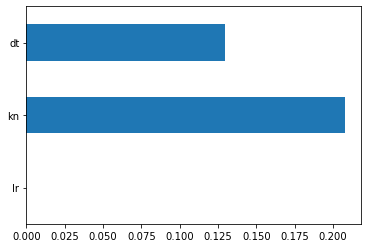

In [140]:
pd.Series(regressor.final_estimator_.coef_.flatten(), index=regressor.named_estimators_.keys()).plot(kind='barh')

In [141]:
from sklearn.model_selection import cross_val_score

In [142]:
cross_val_score(DecisionTreeRegressor( max_depth =5),
                X_train, y_train, 
                cv = 10, 
                scoring = 'neg_mean_squared_error' ).mean()

-0.16085999802800202

In [143]:
cross_val_score(LinearRegression(),
                X_train, y_train, 
                cv = 10, 
                scoring = 'neg_mean_squared_error' ).mean()

-5.773913730365722e+18

In [144]:
cross_val_score(KNeighborsRegressor(),
                X_train, y_train, 
                cv = 10, 
                scoring = 'neg_mean_squared_error' ).mean()

-0.2038832979387883

In [145]:
cross_val_score(StackingRegressor(
    [
        ('lr', LinearRegression()),
        ('kn', KNeighborsRegressor()),
        ('dt', DecisionTreeRegressor())
    ],
LinearRegression()),
                X_train, y_train, 
                cv = 10, 
                scoring = 'neg_mean_squared_error' ).mean()

-0.17682008359577706